In [1]:
"""
Double Delta (Difference-in-Differences) Method for Loyalty Program Impact Analysis
---

🔍 **Situation**:
We wanted to measure the causal impact of a loyalty program on customer spending.
Simply observing spending changes might not isolate the true effect since spending naturally fluctuates over time.
To account for this, we employed the Double Delta (Difference-in-Differences) method to control for natural spending trends and ensure our conclusions were based on causal evidence rather than external factors.

📌 **Task**:
✅ Simulate customer spending data to create a realistic scenario.
✅ Compute the Double Delta Effect using the Difference-in-Differences method to measure the loyalty program's effect.
✅ Run an OLS regression model as a robustness check to confirm statistical significance.

✨ **Action**: 
Created Synthetic Data:
- Simulated 1,000 customer records with baseline spending, natural growth, and potential treatment effects.
Calculated Double Delta Effect:
- Compared spending changes for treated (loyalty program) and control (non-participants) groups both before and after the loyalty program.
- Computed the Difference-in-Differences (DiD) value to isolate the loyalty program’s causal impact.
Performed Robustness Check with Regression:
- Ran an Ordinary Least Squares (OLS) regression model
- Verified that the treatment effect term (treatment:time) was statistically significant.

📈 **Result**:
✅ The Double Delta Effect was $15.10, indicating that customers who joined the loyalty program spent $15.10 more on average than those who did not, after accounting for natural spending growth.
✅ The OLS Regression confirmed this result with a positive and significant interaction term (treatment:time = 15.0951, p < 0.001), strengthening our confidence that the loyalty program caused the increase in spending.

🚀 Next Steps / Additional Analysis
- Explore whether the effect varies across customer segments (e.g., high-value vs low-value customers).
- Test if the observed effect persists over longer time periods.
- Investigate potential confounders such as seasonality or promotional campaigns that may have influenced results.

✍ **Author**: Justin Wall
📅 **Updated**: 03/04/2025
"""

"\nDouble Delta (Difference-in-Differences) Method for Loyalty Program Impact Analysis\n---\n\n🔍 **Situation**:\nWe wanted to measure the causal impact of a loyalty program on customer spending.\nSimply observing spending changes might not isolate the true effect since spending naturally fluctuates over time.\nTo account for this, we employed the Double Delta (Difference-in-Differences) method to control for natural spending trends and ensure our conclusions were based on causal evidence rather than external factors.\n\n📌 **Task**:\n✅ Simulate customer spending data to create a realistic scenario.\n✅ Compute the Double Delta Effect using the Difference-in-Differences method to measure the loyalty program's effect.\n✅ Run an OLS regression model as a robustness check to confirm statistical significance.\n\n✨ **Action**: \nCreated Synthetic Data:\n- Simulated 1,000 customer records with baseline spending, natural growth, and potential treatment effects.\nCalculated Double Delta Effect:\n

In [14]:
# ==========================================
# Create synthetic dataset
# ==========================================
#%%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Create dataset
n = 1000  # Total customers
df = pd.DataFrame({
    "customer_id": np.arange(n),
    "treatment": np.random.choice([0, 1], size=n, p=[0.5, 0.5]),  # 50% join the loyalty program
})

# Baseline spending before the loyalty program
df["pre_spending"] = np.random.normal(100, 20, size=n)

# Natural spending growth (without treatment)
df["spending_growth"] = np.random.normal(10, 5, size=n)  

# Treatment effect (applies only to treated customers)
treatment_effect = np.random.normal(15, 5, size=n)  # Additional boost from the loyalty program

# Post-treatment spending
df["post_spending"] = df["pre_spending"] + df["spending_growth"] + (df["treatment"] * treatment_effect)

# Show sample data
print(df.shape)
df.head()
#%%

(1000, 5)


,customer_id,treatment,pre_spending,spending_growth,post_spending
0,0,0,103.554020,2.968413,106.522433
1,1,1,73.293113,9.584472,94.628759
2,2,1,107.603957,2.476398,119.064351
3,3,1,112.211715,13.800280,135.801773
4,4,0,111.195809,10.412199,121.608008


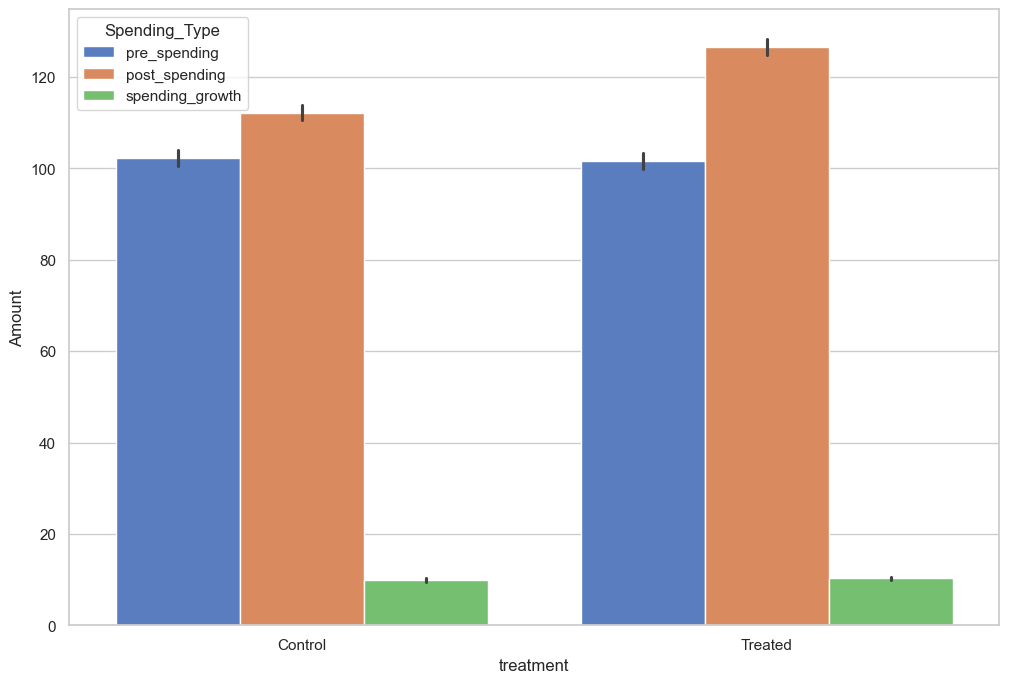

In [ ]:
# Melt the DataFrame to long format for seaborn
df_melted = df.melt(id_vars=['customer_id', 'treatment'], value_vars=['pre_spending', 'post_spending', 'spending_growth'], var_name='Spending_Type', value_name='Amount')
df_melted['treatment'] = df_melted['treatment'].map({0: 'Control', 1: 'Treated'})

# Set the seaborn style
sns.set_theme(style="whitegrid")

# Create a figure
plt.figure(figsize=(12, 8))

# Plot all spending types on the same chart
bar_plot = sns.barplot(x='treatment', y='Amount', hue='Spending_Type', data=df_melted, palette='muted')

# Add the value on top of the bar
for p in bar_plot.patches:
    bar_plot.annotate(f'${p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Set labels and title
bar_plot.set_xlabel('Treatment')
bar_plot.set_ylabel('Amount ($)')
bar_plot.set_title('Spending Comparison by Treatment')

# Show the plot
plt.tight_layout()
plt.show()

In [3]:
# ==========================================
# Compute Double Delta Effect               
# ==========================================
#%%
# Compute average spending before & after for both groups
pre_treated = df[df["treatment"] == 1]["pre_spending"].mean()
post_treated = df[df["treatment"] == 1]["post_spending"].mean()
pre_control = df[df["treatment"] == 0]["pre_spending"].mean()
post_control = df[df["treatment"] == 0]["post_spending"].mean()

# Calculate Double Delta (Difference-in-Differences)
double_delta = (post_treated - pre_treated) - (post_control - pre_control)

# Print results
print(f"Pre-Treatment Spending (Treated): ${pre_treated:.2f}")
print(f"Post-Treatment Spending (Treated): ${post_treated:.2f}")
print(f"Pre-Treatment Spending (Control): ${pre_control:.2f}")
print(f"Post-Treatment Spending (Control): ${post_control:.2f}")
print(f"Double Delta Effect: ${double_delta:.2f}")
# Pre-Treatment Spending (Treated): $101.63
# Post-Treatment Spending (Treated): $126.60
# Pre-Treatment Spending (Control): $102.32
# Post-Treatment Spending (Control): $112.20
# Double Delta Effect: $15.10
#%%

Pre-Treatment Spending (Treated): $101.63
Post-Treatment Spending (Treated): $126.60
Pre-Treatment Spending (Control): $102.32
Post-Treatment Spending (Control): $112.20
Double Delta Effect: $15.10


In [4]:
# ==========================================
# Robustness Check using Regression         
# ==========================================
#%%
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Create a time indicator (0 = pre, 1 = post)
df_long = pd.melt(df, id_vars=["customer_id", "treatment"], value_vars=["pre_spending", "post_spending"],
                  var_name="time", value_name="spending")
df_long["time"] = df_long["time"].map({"pre_spending": 0, "post_spending": 1})

# Run Difference-in-Differences regression
model = smf.ols("spending ~ treatment * time", data=df_long).fit()
print(model.summary())
# - treatment: -0.6966, pval: 0.585
# - time: 9.8792, pval: 0.000
# - treatment:time: 15.0951, 0.000
#%%

                            OLS Regression Results                            
Dep. Variable:               spending   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     166.3
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           3.02e-96
Time:                        20:33:12   Log-Likelihood:                -8844.2
No. Observations:                2000   AIC:                         1.770e+04
Df Residuals:                    1996   BIC:                         1.772e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        102.3241      0.899    113.